## Summary metrics for Genome in a Bottle samples (n=7) 
- Author : Prathima Vembu 
- Languages : SQL, R 
- Input dataset - Genome in a bottle samples (n=7)
- Structural variant caller : CNVnator0.3.3


### 1. Installing and loading necessary packages in R

In [1]:
#helps connecting R to DBMS
install.packages("DBI") 
#helps to work with data on cloud storage
install.packages("bigrquery") 
#package to restructure and aggregate dataframes
install.packages("reshape2")
#data manipulation
install.packages("dplyr")
#package to tidy data
install.packages("tidyr")
#airithmetic conversion for arbitrary precision floating point numbers
install.packages("Rmpfr")
#multiple precision airithmetic
install.packages("gmp")
#package for creating graphics 
install.packages("ggplot2")
#ggplot2 extension that enables the rendering of complex formatted plot labels
install.packages("ggtext")
#for elegant data visualization in R
install.packages("ggpubr")
#Package provide missing functionality to ggplot2
install.packages("ggforce")
#Plotting correlation profiles in R
install.packages("corrplot")

library(DBI)
library(bigrquery)
library(reshape2)
library(dplyr)
library(tidyr)
library(Rmpfr)
library(gmp)
library(ggplot2)
library(ggtext)
library(ggpubr)
library(ggforce)
library(corrplot)



The downloaded binary packages are in
	/var/folders/q2/qzmn1q3x3hv9r0qyfzrf0yf80000gn/T//Rtmpc51akV/downloaded_packages

The downloaded binary packages are in
	/var/folders/q2/qzmn1q3x3hv9r0qyfzrf0yf80000gn/T//Rtmpc51akV/downloaded_packages

The downloaded binary packages are in
	/var/folders/q2/qzmn1q3x3hv9r0qyfzrf0yf80000gn/T//Rtmpc51akV/downloaded_packages

The downloaded binary packages are in
	/var/folders/q2/qzmn1q3x3hv9r0qyfzrf0yf80000gn/T//Rtmpc51akV/downloaded_packages

The downloaded binary packages are in
	/var/folders/q2/qzmn1q3x3hv9r0qyfzrf0yf80000gn/T//Rtmpc51akV/downloaded_packages

The downloaded binary packages are in
	/var/folders/q2/qzmn1q3x3hv9r0qyfzrf0yf80000gn/T//Rtmpc51akV/downloaded_packages

The downloaded binary packages are in
	/var/folders/q2/qzmn1q3x3hv9r0qyfzrf0yf80000gn/T//Rtmpc51akV/downloaded_packages

The downloaded binary packages are in
	/var/folders/q2/qzmn1q3x3hv9r0qyfzrf0yf80000gn/T//Rtmpc51akV/downloaded_packages

The downloaded binary packages 


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidyr'


The following object is masked from 'package:reshape2':

    smiths


Loading required package: gmp


Attaching package: 'gmp'


The following objects are masked from 'package:base':

    %*%, apply, crossprod, matrix, tcrossprod


C code of R package 'Rmpfr': GMP using 64 bits per limb



Attaching package: 'Rmpfr'


The following object is masked from 'package:gmp':

    outer


The following objects are masked from 'package:stats':

    dbinom, dgamma, dnbinom, dnorm, dpois, dt, pnorm


The following objects are masked from 'package:base':

    cbind, pmax, pmin, rbind


corrplot 0.92 loaded



### 2. Authenticating and connecting to Google cloud platform 

In [2]:
#dbconnect creates a connection to the DBMS
gcp_mvp_dev_account<-dbConnect(bigquery(),"gbsc-gcp-project-mvp-dev", 
                       dataset="giab-cnvnator", 
                       billing = "gbsc-gcp-project-mvp")

### 3. Analysis pipeline
- For high quality cnv's, it is advised to filter for the mapping quality score (Refer: [CNVnator paper](https://pubmed.ncbi.nlm.nih.gov/21324876/))
- Ideally calls that have a q0>0.5 are considered true calls/high quality calls
- All analysis have results shown for before (BF) and after (AF) filering for q0>0.5

##### 3.1. Number of CNV's called per GIAB sample, **before** and **after** filtering for q0>0.5

In [4]:
#Number of CNV's called for each GIAB sample before (BF) and after (AF)filtering for q0>0.5
cnv_count_per_giab_sample_sql<-"SELECT SPLIT(sample_name, '_')[OFFSET(18)] AS GIAB_Sample_ID, 
COUNT(reference_name) AS CNVs_BF, 
COUNTIF(natorQ0>0.5) AS CNVs_AF, 
COUNTIF(SVTYPE='DEL') AS Deletions_BF, 
COUNTIF(SVTYPE='DEL' AND natorQ0>0.5) AS Deletions_AF,
COUNTIF(SVTYPE='DUP') AS Duplications_BF,
COUNTIF(SVTYPE='DUP' AND natorQ0>0.5) AS Duplications_AF,
FROM `gbsc-gcp-project-mvp-dev.giab_cnvnator.giab_7samples_vcf__chr*`c, UNNEST(call) AS cal
INNER JOIN `gbsc-gcp-project-mvp-dev.giab_cnvnator.giab_7samples_vcf__sample_info`p
ON cal.sample_id=p.sample_id
GROUP BY 1 "

cnv_count_per_giab_sample<-dbGetQuery(gcp_mvp_dev_account, cnv_count_per_giab_sample_sql)
cnv_count_per_giab_sample

GIAB_Sample_ID,CNVs_BF,CNVs_AF,Deletions_BF,Deletions_AF,Duplications_BF,Duplications_AF
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
GM24385,8262,5426,6747,4714,1515,712
GM24695,8777,5754,7259,5001,1518,753
GM24631,8863,5723,7200,4837,1663,886
GM12878,8838,5843,7216,4990,1622,853
GM24694,13843,4124,12363,3385,1480,739
GM24143,9212,6083,7688,5337,1524,746
GM24149,8626,5527,7020,4734,1606,793


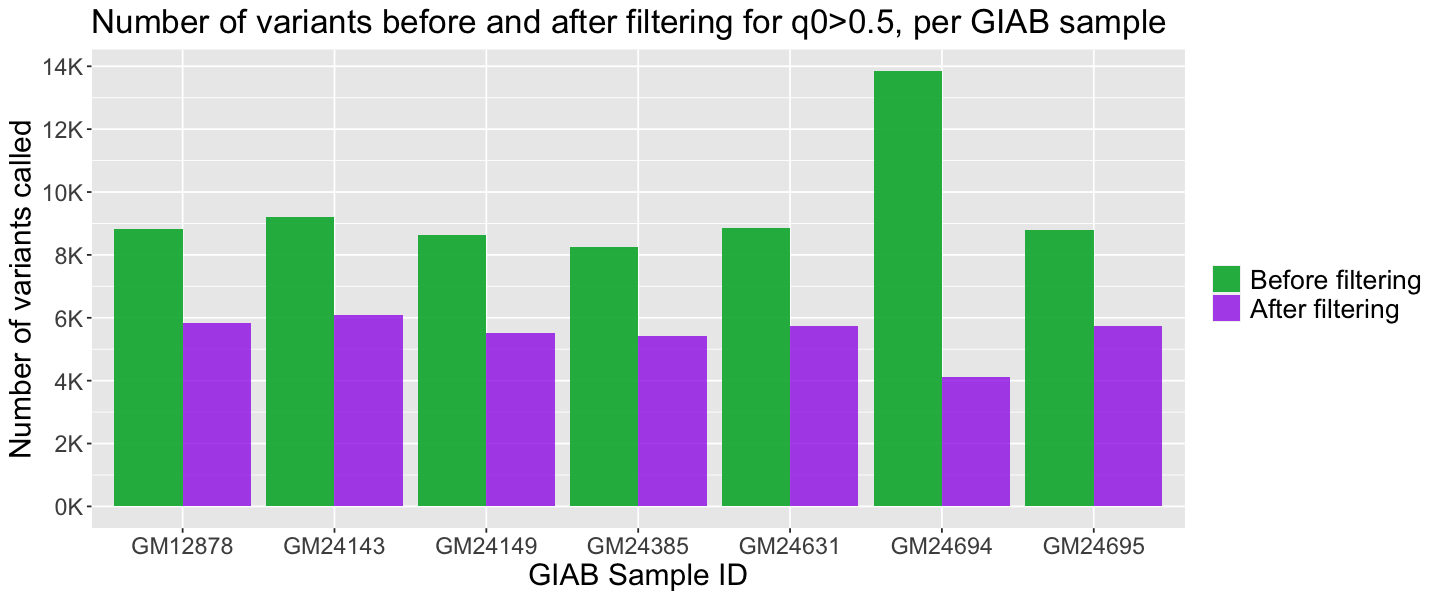

In [9]:
#Plot showing the number of cnvs called before and after filtering for q0>0.5
#Plotting the number of variants called before and after filtering for q0>0.5
options(repr.plot.width=12, repr.plot.height=5)

#Extracting GIAB_ID, SV call before filtering and afer filtering columns
reduction_in_cnv_call_af<-cnv_count_per_giab_sample[,1:3]
reduction_in_cnv_call_af_melt <- melt(reduction_in_cnv_call_af, id.vars='GIAB_Sample_ID')

ggplot(reduction_in_cnv_call_af_melt, aes(x=GIAB_Sample_ID, y=value, fill=variable))+
geom_bar(stat='identity', position='dodge')+
scale_y_continuous(breaks = c(0,2000,4000,6000,8000,10000,12000,14000,16000,18000),
                  labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Number of variants before and after filtering for q0>0.5, per GIAB sample", x="GIAB Sample ID", y = "Number of variants called")+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18), legend.title = element_blank(), 
     legend.text = element_text(size = 16))+
scale_fill_manual(labels = c("Before filtering", "After filtering"), values=c("#10b447f4","#9d23e9c3"))

##### 3.2. Number of deletions and duplications called per GIAB sample, **before** and **after** filtering for q0>0.5

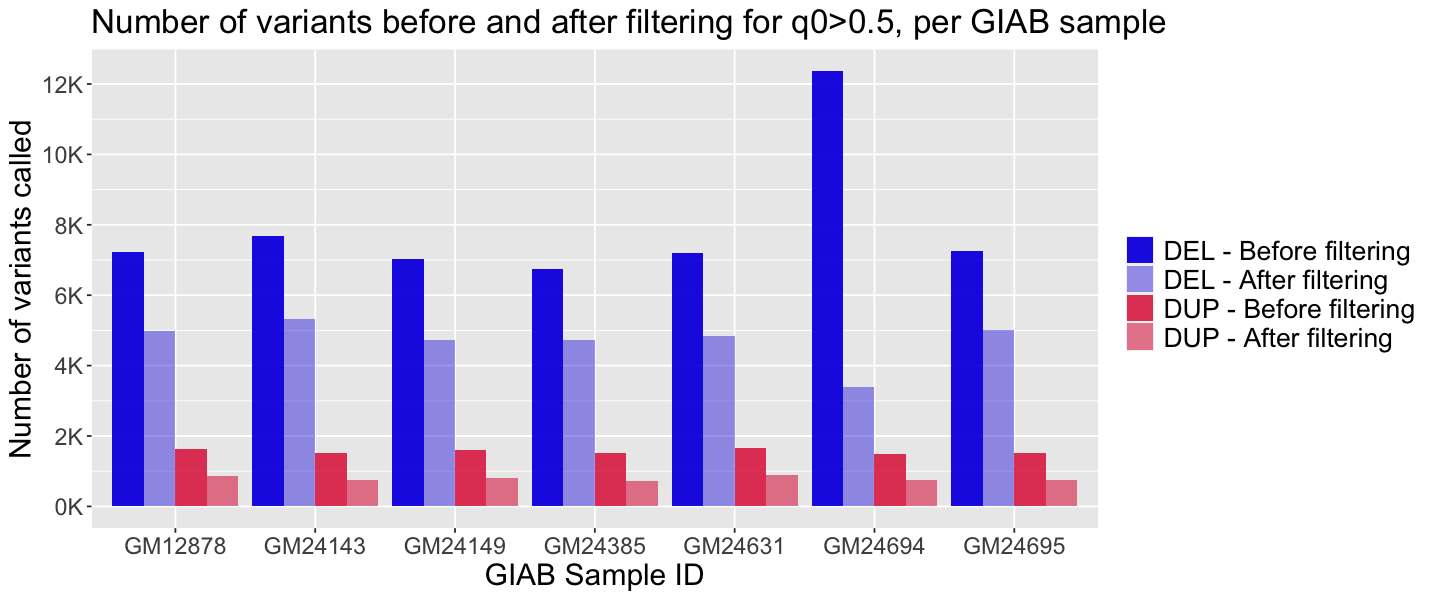

In [8]:
#Plot showing the number of deletions and duplications called before and after filtering for q0>0.5
#Plotting the number of variants called before and after filtering for q0>0.5
options(repr.plot.width=12, repr.plot.height=5)

#Extracting GIAB_ID, SV call before filtering and afer filtering columns
reduction_in_del_dup_call_af<-cnv_count_per_giab_sample[,c(1,4,5,6,7)]
reduction_in_del_dup_call_af_melt <- melt(reduction_in_del_dup_call_af, id.vars='GIAB_Sample_ID')

ggplot(reduction_in_del_dup_call_af_melt, aes(x=GIAB_Sample_ID, y=value, fill=variable))+
geom_bar(stat='identity', position='dodge')+
scale_y_continuous(breaks = c(0,2000,4000,6000,8000,10000,12000,14000,16000,18000),
                  labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Number of variants before and after filtering for q0>0.5, per GIAB sample", x="GIAB Sample ID", y = "Number of variants called")+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18), legend.title = element_blank(), 
     legend.text = element_text(size = 16))+
scale_fill_manual(labels = c("DEL - Before filtering", "DEL - After filtering", "DUP - Before filtering", "DUP - After filtering"), 
                  values=c("#1518e3f4","#1519e36a","#df0c3ace","#df0c3a87"))

##### 3.3. Number of CNV's called per chromosome, **before** and **after** filtering for q0>0.5

In [11]:
#Number of CNV calls per chromosome for GiAB samples 
giab_cnv_count_per_chr_sql<-"SELECT CASE WHEN SAFE_CAST(REGEXP_REPLACE(reference_name, '^chr', '') AS INT64) < 10
THEN CONCAT('0', REGEXP_REPLACE(reference_name, '^chr', ''))
ELSE REGEXP_REPLACE(reference_name, '^chr', '') END AS Chromosome_number, 
COUNT(reference_name) AS BF_SV_count,
COUNTIF(natorQ0>0.5) AS AF_SV_Count, 
COUNTIF(SVTYPE='DEL') AS BF_Deletion_Count, 
COUNTIF(SVTYPE='DEL' AND natorQ0>0.5) AS AF_Deletion_Count,
COUNTIF(SVTYPE='DUP') AS BF_Duplication_Count,
COUNTIF(SVTYPE='DUP' AND natorQ0>0.5) AS AF_Duplication_Count,
FROM `gbsc-gcp-project-mvp-dev.giab_cnvnator.giab_7samples_vcf__chr*`
GROUP BY 1
ORDER BY 1"

giab_cnv_count_per_chr<-dbGetQuery(gcp_mvp_dev_account, giab_cnv_count_per_chr_sql)
giab_cnv_count_per_chr

Chromosome_number,BF_SV_count,AF_SV_Count,BF_Deletion_Count,AF_Deletion_Count,BF_Duplication_Count,AF_Duplication_Count
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
01,5266,2791,4562,2476,704,315
02,4029,1711,3516,1598,513,113
03,3207,1414,2636,993,571,421
04,3773,1916,3314,1587,459,329
05,2717,946,2395,779,322,167
06,2264,857,2007,673,257,184
07,4249,2746,3617,2430,632,316
08,2895,1734,2364,1392,531,342
09,4708,3082,3649,2656,1059,426


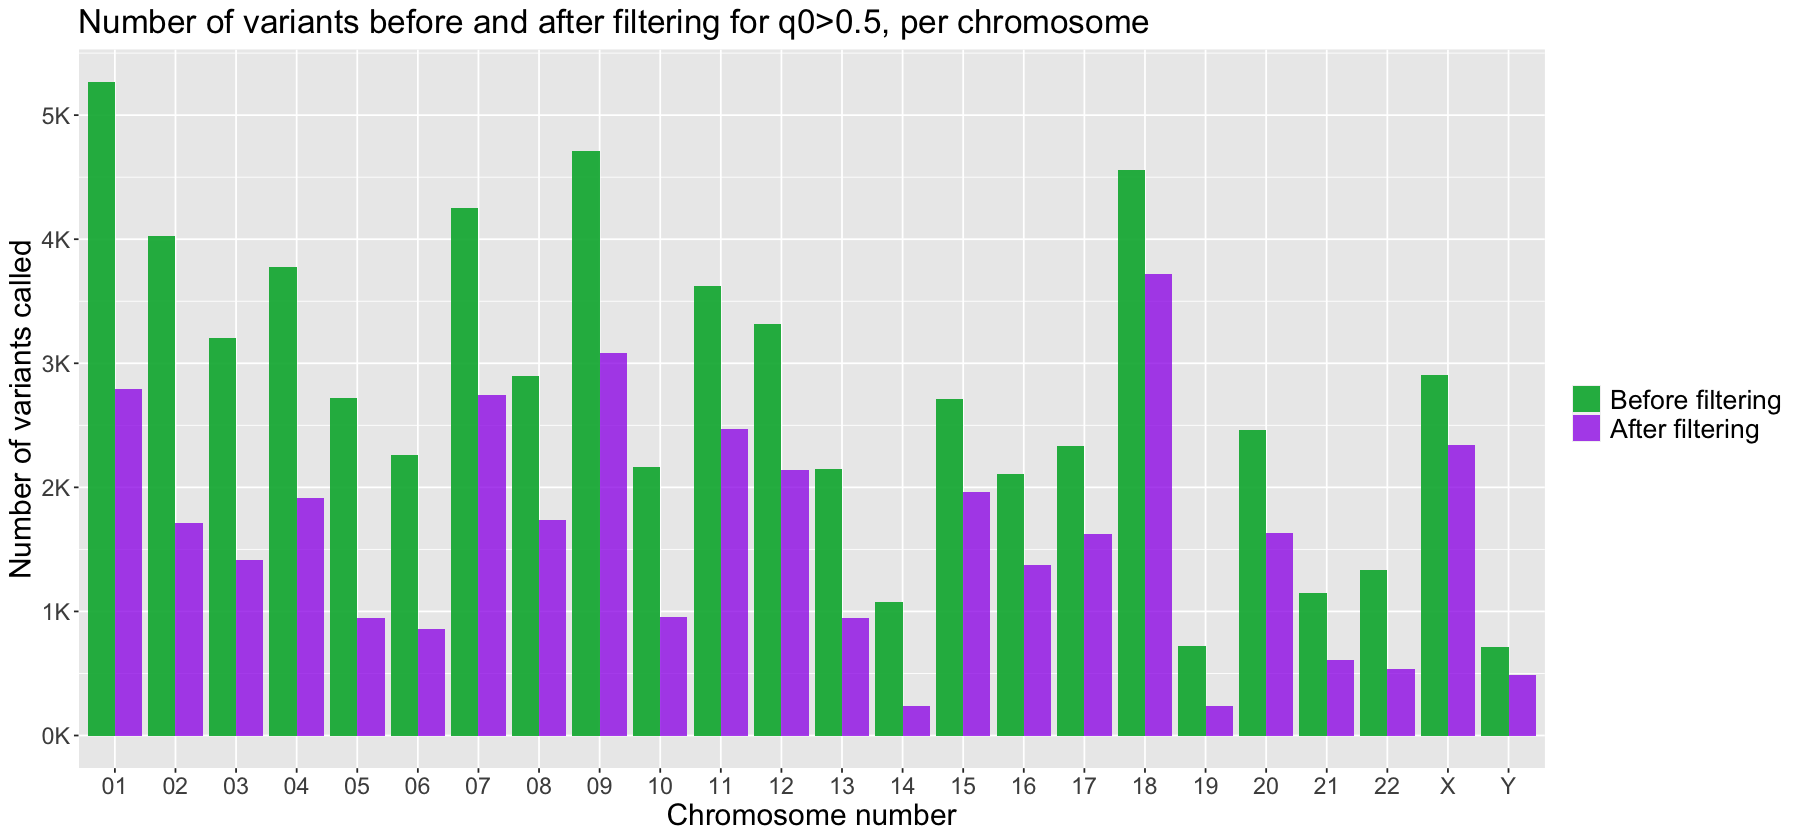

In [12]:
#Plot showing the number of cnvs per chromosome before and after filtering for q0>0.5
options(repr.plot.width=15, repr.plot.height=7)

#Extracting GIAB_ID, SV call before filtering and afer filtering columns
reduction_in_cnv_call_per_chr_af<-giab_cnv_count_per_chr[,1:3]
reduction_in_cnv_call_per_chr_af_melt <- melt(reduction_in_cnv_call_per_chr_af, id.vars='Chromosome_number')

ggplot(reduction_in_cnv_call_per_chr_af_melt, aes(x=Chromosome_number, y=value, fill=variable))+
geom_bar(stat='identity', position='dodge')+
scale_y_continuous(breaks = c(0,1000,2000,3000,4000,5000),
                  labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Number of variants before and after filtering for q0>0.5, per chromosome", x="Chromosome number", y = "Number of variants called")+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18), legend.title = element_blank(), 
     legend.text = element_text(size = 16))+
scale_fill_manual(labels = c("Before filtering", "After filtering"), values=c("#10b447f4","#9d23e9c3"))

##### 3.4. Number of deletions and duplications called per chromosome, **before** and **after** filtering for q0>0.5

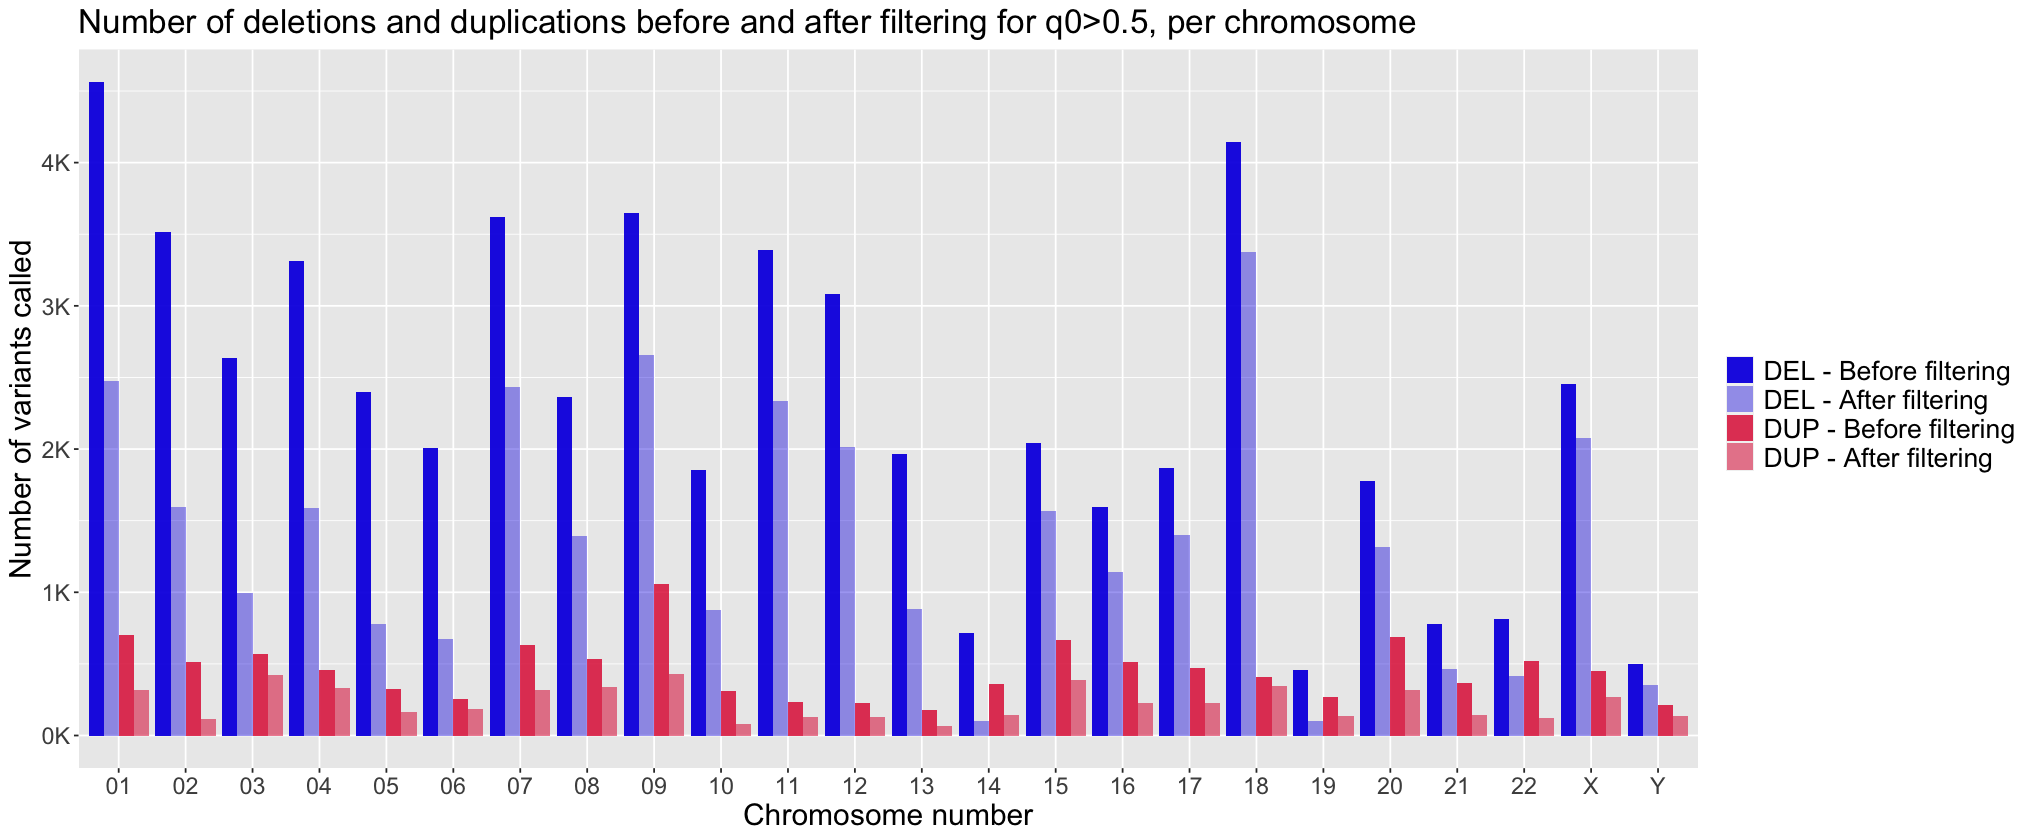

In [13]:
#Plot showing the number of dels and dups per chromosome before and after filtering for q0>0.5
options(repr.plot.width=17, repr.plot.height=7)

reduction_in_del_dup_call_per_chr_af<-giab_cnv_count_per_chr[,c(1,4,5,6,7)]
reduction_in_del_dup_call_per_chr_af_melt <- melt(reduction_in_del_dup_call_per_chr_af, id.vars='Chromosome_number')

ggplot(reduction_in_del_dup_call_per_chr_af_melt, aes(x=Chromosome_number, y=value, fill=variable))+
geom_bar(stat='identity', position='dodge')+
scale_y_continuous(breaks = c(0,1000,2000,3000,4000,5000),
                  labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Number of deletions and duplications before and after filtering for q0>0.5, per chromosome", x="Chromosome number", 
     y = "Number of variants called")+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18), legend.title = element_blank(), 
     legend.text = element_text(size = 16))+
scale_fill_manual(labels = c("DEL - Before filtering", "DEL - After filtering", "DUP - Before filtering", "DUP - After filtering"), 
                  values=c("#1518e3f4","#1519e36a","#df0c3ace","#df0c3a87"))

##### 3.5. Distribution of q0 values across all samples 

In [14]:
#Distribution of q0 value for the GiAB samples 
q0_val_sql<-"SELECT natorQ0 
FROM `gbsc-gcp-project-mvp-dev.giab_cnvnator.giab_7samples_vcf__chr*`"

q0_val<-dbGetQuery(gcp_mvp_dev_account, q0_val_sql)
head(q0_val)

natorQ0
<dbl>
0.00135685
0.00194175
0.09090910
0.72941200
0.65189900
0.68639100


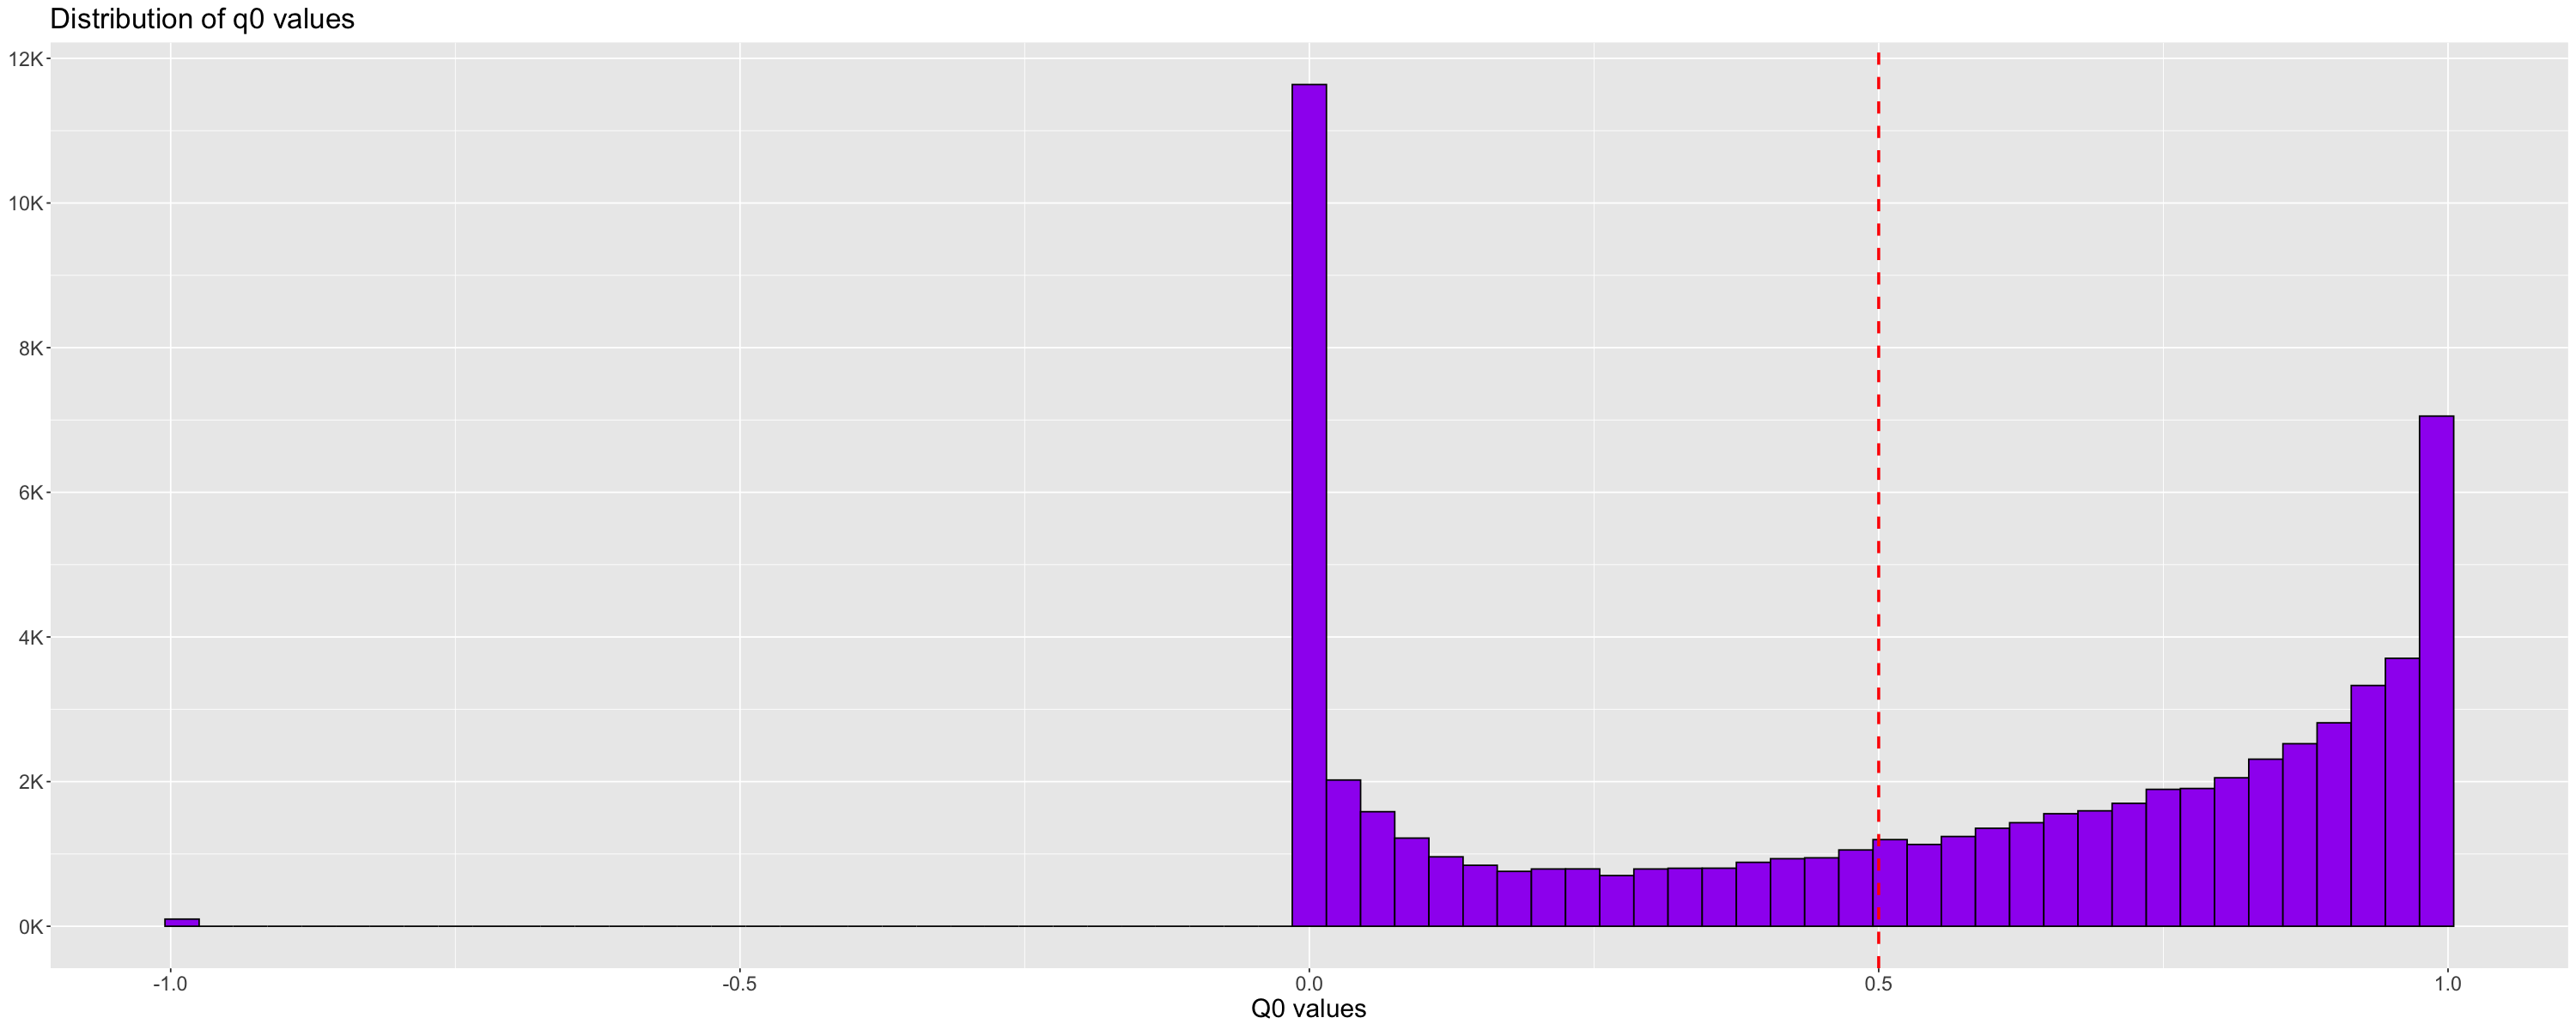

In [ ]:
#Plotting the q0 values 
options(repr.plot.width=25, repr.plot.height=10)

ggplot(q0_val, aes(x=natorQ0))+ 
geom_histogram(binwidth=0.03,colour="black", fill="purple")+
scale_y_continuous(breaks = c(0, 2000, 4000, 6000, 8000, 10000, 12000),
                  labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Distribution of q0 values ", x="Q0 values")+
geom_vline(xintercept = 0.5, colour="red", linetype="dashed", size=1)+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18), axis.title.y = element_blank())

##### 3.6. Distribution of p-values (p1,p2,p3,p4 - before filtering for q0)

In [15]:
#Extracting the p-values for GIAB samples 
p_val_sql<-"SELECT natorP1, natorP2, natorP3, natorP4 
FROM `gbsc-gcp-project-mvp-dev.giab_cnvnator.giab_7samples_vcf__chr*`"

p_val<-dbGetQuery(gcp_mvp_dev_account, p_val_sql)
#Setting the ID column which will subsequently help to group the data
p_val$ID <- seq.int(nrow(p_val))
p_val<-select(p_val, ID, natorP1, natorP2, natorP3, natorP4)
p_val<-log10(p_val+1)
head(p_val)

,ID,natorP1,natorP2,natorP3,natorP4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3010300,8.651850e-12,3.012048e+00,1.153577e-11,4.623238e+00
2,0.4771213,4.765600e-09,5.617129e+00,3.763433e-05,6.876442e+00
3,0.6020600,1.033055e-11,2.055989e-04,1.472653e-11,4.223754e-14
4,0.6989700,1.472653e-11,2.272944e-06,2.563510e-11,0.000000e+00
5,0.7781513,9.613188e-12,1.775326e-09,1.331052e-11,2.892982e-16
6,0.8450980,1.384292e-11,2.172489e-10,3.968305e-09,6.871651e-03


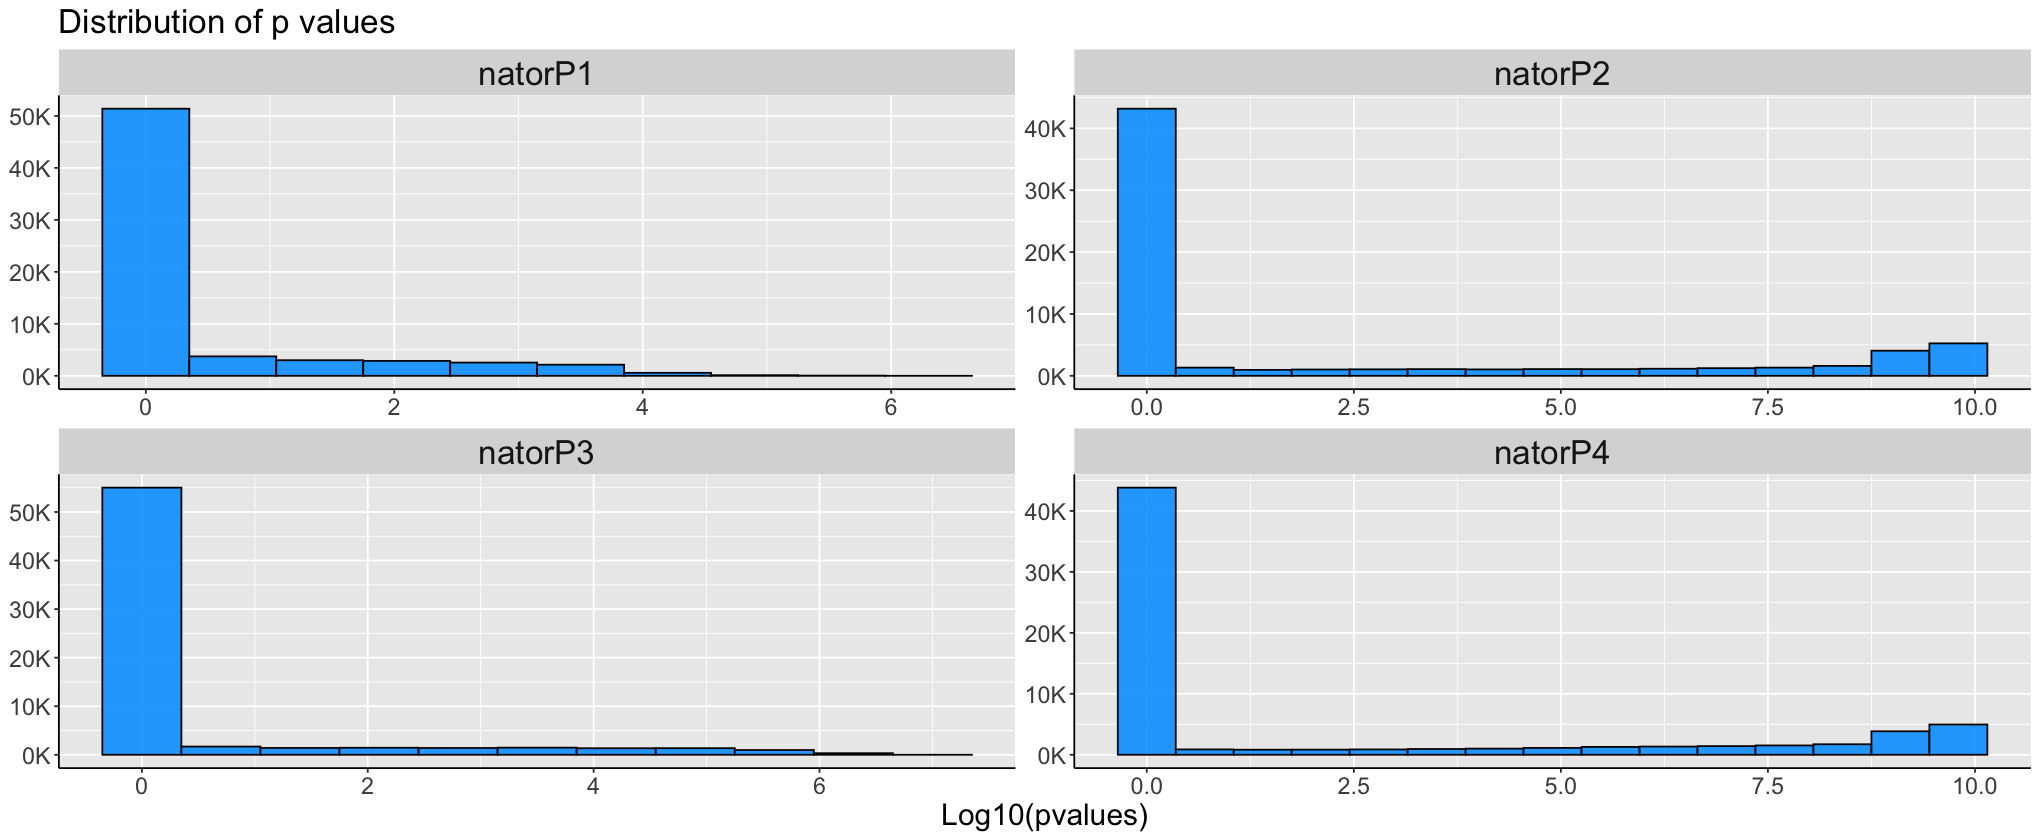

In [16]:
#Plotting the p value distributions 
#Plotting the distribution of  p-values for GIAB samples
var_to_plot = c("natorP1","natorP2","natorP3","natorP4")
ID = "ID"
P<-ggplot(pivot_longer(p_val[,c(var_to_plot,ID)],-ID),
aes(x=value)) +
geom_histogram(binwidth = 0.7,colour="black", fill="#07a4ffec") +
scale_y_continuous(breaks = c(0, 10000, 20000, 30000, 40000, 50000),
                  labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Distribution of p values ", x="Log10(pvalues)")+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18), axis.title.y = element_blank(), 
     strip.text = element_text(size = 20), axis.line=element_line())

P+facet_wrap(~name, scales='free')

##### 3.7. Distribution of p-values (p1,p2,p3,p4 - after filtering for q0)

In [17]:
#Extracting the p-values for GiAB samples after filtering for q0>0.5
p_val_af_sql<-"SELECT natorQ0, natorP1, natorP2, natorP3, natorP4 
FROM `gbsc-gcp-project-mvp-dev.giab_cnvnator.giab_7samples_vcf__chr*`
WHERE natorQ0>0.5"

p_val_af<-dbGetQuery(gcp_mvp_dev_account, p_val_af_sql)
#Setting the ID column which will subsequently help to group the data
p_val_af$ID <- seq.int(nrow(p_val_af))
p_val_af<-select(p_val_af, ID, natorQ0, natorP1, natorP2, natorP3, natorP4)
p_val_af<-log10(p_val_af+1)
head(p_val_af)

,ID,natorQ0,natorP1,natorP2,natorP3,natorP4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3010300,0.2273233,9.817818e-13,3.857310e-15,1.010422e-12,1.793649e-14
2,0.4771213,0.1895905,1.541997e-09,9.457911e+00,1.847730e-03,9.457942e+00
3,0.6020600,0.1882004,0.000000e+00,8.025740e+00,0.000000e+00,8.226058e+00
4,0.6989700,0.1782501,2.044294e-04,5.612778e-08,2.681694e+00,1.038246e-08
5,0.7781513,0.1901997,1.977560e-10,4.465857e+00,3.803945e-05,5.200144e+00
6,0.8450980,0.3009251,1.860573e-12,9.259632e+00,1.966360e-12,9.270299e+00


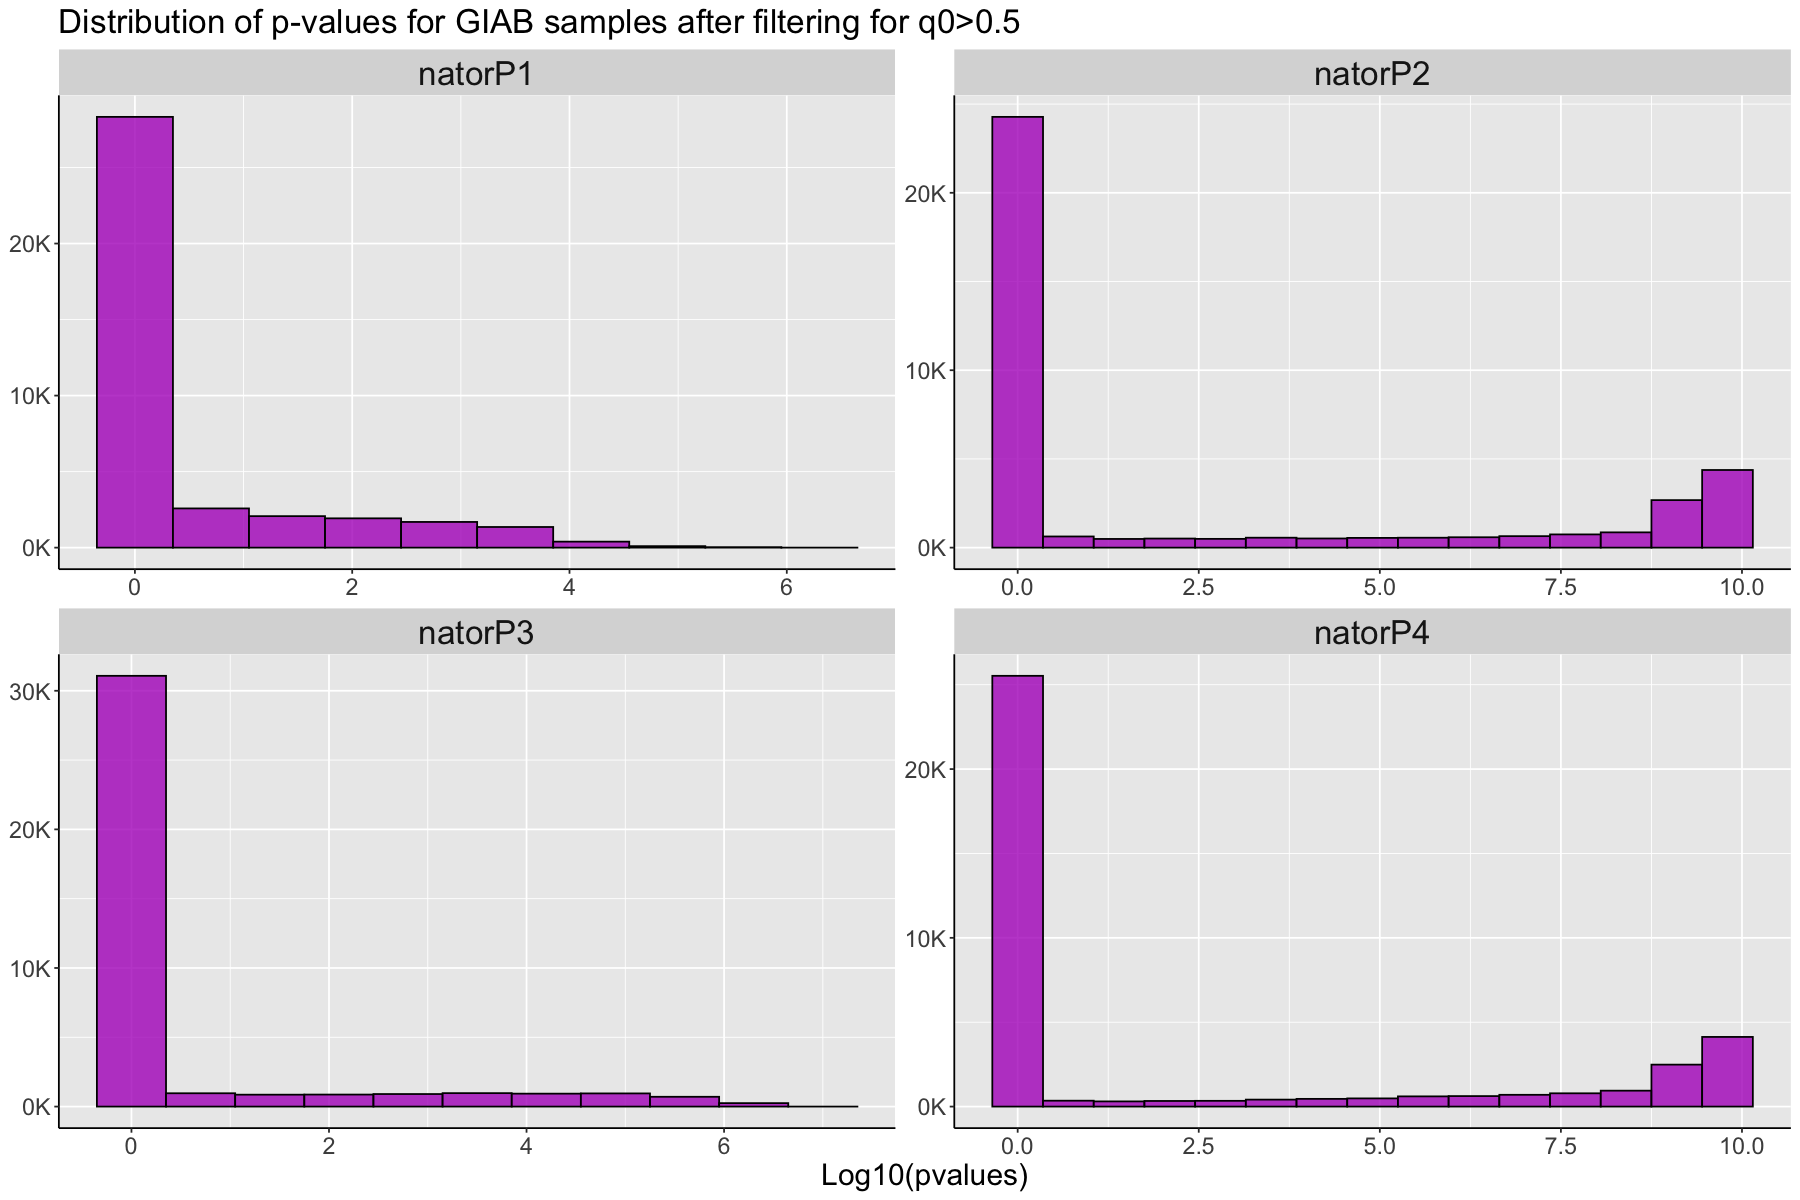

In [18]:
#Plotting the distribution of p-values for GiAB samples
options(repr.plot.width=15, repr.plot.height=10)
var_to_plot = c("natorP1","natorP2","natorP3","natorP4")
ID = "ID"
P<-ggplot(pivot_longer(p_val_af[,c(var_to_plot,ID)],-ID),
aes(x=value)) +
geom_histogram(binwidth = 0.7,colour="black", fill="#b102c4cb") +
scale_y_continuous(breaks = c(0, 10000, 20000, 30000, 40000, 50000),
                  labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Distribution of p-values for GIAB samples after filtering for q0>0.5", x="Log10(pvalues)")+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18), axis.title.y = element_blank(), 
     strip.text = element_text(size = 20), axis.line=element_line())

P+facet_wrap(~name, scales='free')

##### 3.8. Correlation profile between q0 and p-values for GIAB samples (before filtering for q0)

,natorQ0,natorP1,natorP2,natorP3,natorP4
natorQ0,1.00000000,0.01927433,0.15407800,0.04036876,0.14558167
natorP1,0.01927433,1.00000000,0.07771225,0.03459312,0.06861168
natorP2,0.15407800,0.07771225,1.00000000,0.01492002,0.93508849
natorP3,0.04036876,0.03459312,0.01492002,1.00000000,0.04358872
natorP4,0.14558167,0.06861168,0.93508849,0.04358872,1.00000000


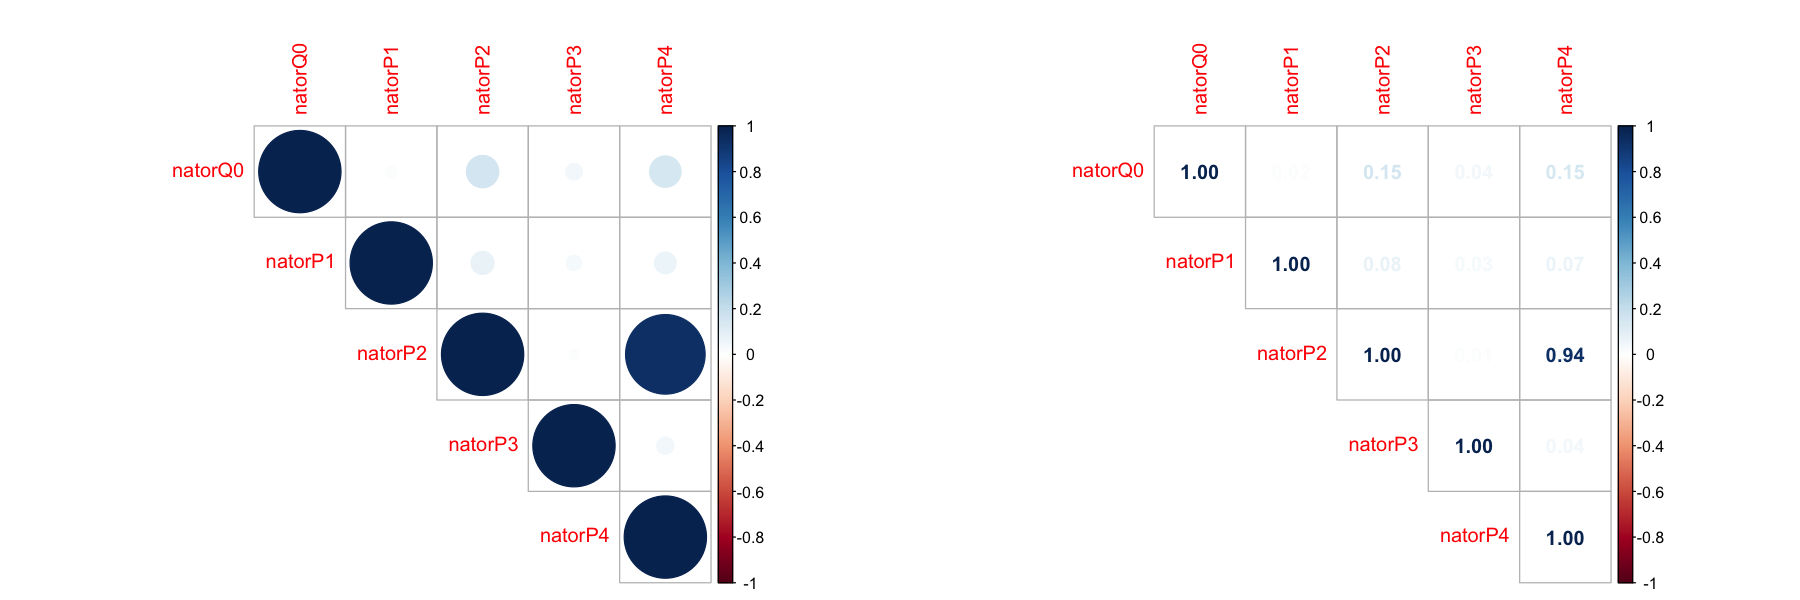

In [19]:
#Plotting the correlation between Q0 and p-values for GiAB Samples
options(repr.plot.width=15, repr.plot.height=5)
#Extracting the q0 and p-values for GiAB samples 
p_q0_val_giab_bf_sql<-"SELECT natorQ0, natorP1, natorP2, natorP3, natorP4 
FROM `gbsc-gcp-project-mvp-dev.giab_cnvnator.giab_7samples_vcf__chr*`"

p_q0_val_giab_bf<-dbGetQuery(gcp_mvp_dev_account, p_q0_val_giab_bf_sql)

#Processing the data for plotting
p_q0_val_giab_bf_new<-p_q0_val_giab_bf[,1:5]
corr_p_q0_val_giab_bf_new<-cor(p_q0_val_giab_bf_new, use = "complete.obs")
corr_p_q0_val_giab_bf_new
par(mfrow=c(1,2))
corrplot(corr_p_q0_val_giab_bf_new, method="circle",type="upper")
corrplot(corr_p_q0_val_giab_bf_new, method="number",type="upper")

##### 3.9. Correlation profile between q0 and p-values for GIAB samples (after filtering for q0)

,natorQ0,natorP1,natorP2,natorP3,natorP4
natorQ0,1.0000000000,0.0009057822,-0.074446140,0.009580454,-0.07818201
natorP1,0.0009057822,1.0000000000,0.084984865,0.041441046,0.07793011
natorP2,-0.0744461398,0.0849848646,1.000000000,0.007181043,0.93555466
natorP3,0.0095804543,0.0414410463,0.007181043,1.000000000,0.03426026
natorP4,-0.0781820140,0.0779301102,0.935554660,0.034260259,1.00000000


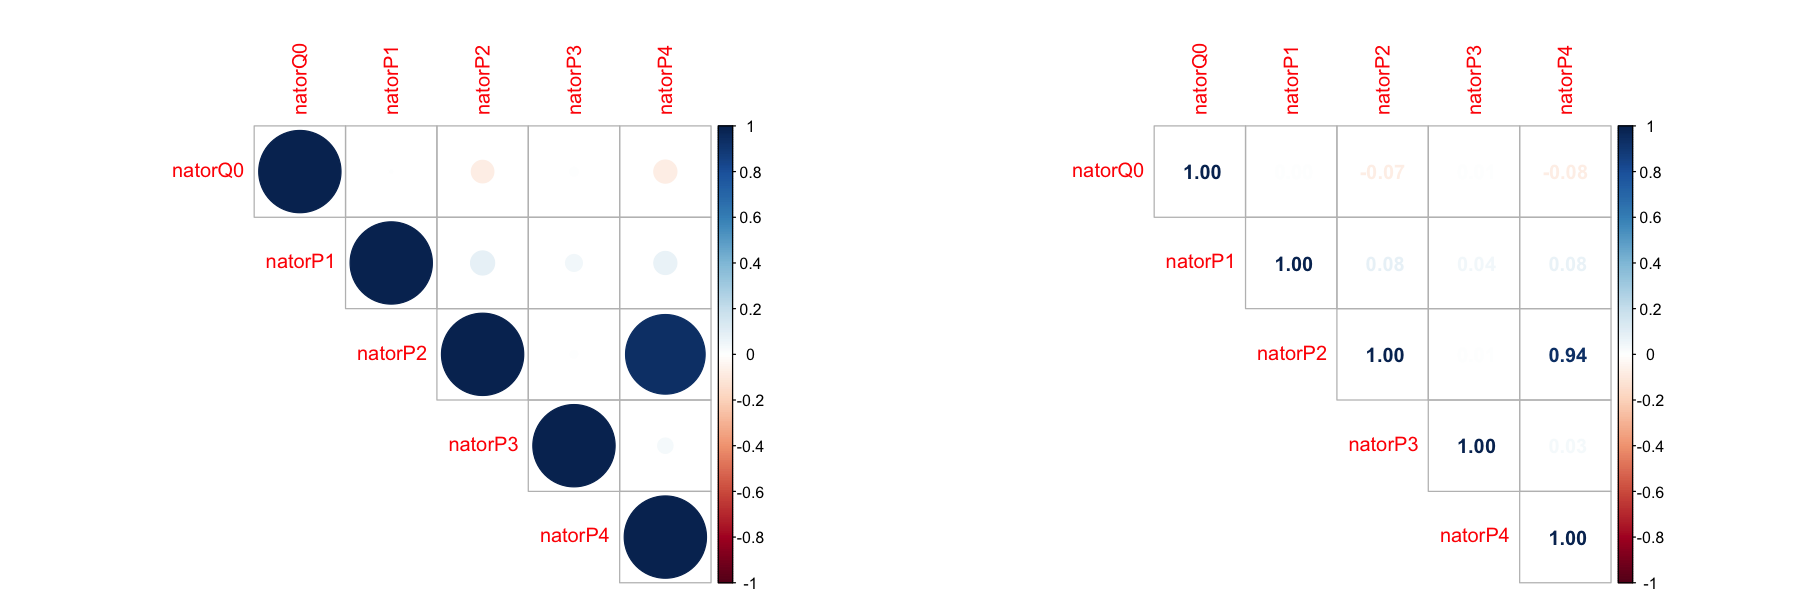

In [21]:
#Plotting the correlation between Q0 and p-values for GiAB Samples
options(repr.plot.width=15, repr.plot.height=5)
#Extracting the q0 and p-values for GiAB samples 
p_q0_val_giab_af_sql<-"SELECT natorQ0, natorP1, natorP2, natorP3, natorP4 
FROM `gbsc-gcp-project-mvp-dev.giab_cnvnator.giab_7samples_vcf__chr*`
WHERE natorQ0>0.5"

p_q0_val_giab_af<-dbGetQuery(gcp_mvp_dev_account, p_q0_val_giab_af_sql)

#Processing the data for plotting
p_q0_val_giab_af_new<-p_q0_val_giab_af[,1:5]
corr_p_q0_val_giab_af_new<-cor(p_q0_val_giab_af_new, use = "complete.obs")
corr_p_q0_val_giab_af_new
par(mfrow=c(1,2))
corrplot(corr_p_q0_val_giab_af_new, method="circle",type="upper")
corrplot(corr_p_q0_val_giab_af_new, method="number",type="upper")